In [8]:
import seaborn as sns
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import janitor 
from obspy.signal.trigger import classic_sta_lta
from scipy.fft import fft, ifft, fftfreq

In [9]:
class SismicDataset(Dataset):
    def __init__(self, max_length=572427):
        # Cargar el catálogo CSV
        self.cat = pd.read_csv('./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
        self.data_directory = './data/lunar/training/data/S12_GradeA'
        self.max_length = max_length  # Define la longitud máxima de las secuencias

    def __len__(self):
        return len(self.cat)

    def __getitem__(self, idx):
        # Obtener los datos de la fila correspondiente
        row = self.cat.iloc[idx]
        test_filename = row['filename']
        arrival_time_rel = row['time_rel(sec)']

        # Construir la ruta al archivo .mseed
        mseed_file = os.path.join(self.data_directory, f'{test_filename}.mseed')

        # Leer los datos de la señal usando obspy
        st = read(mseed_file)
        tr = st.traces[0]
        tr_data = tr.data.astype(np.float32)  # Convertir los datos a float32
        tr_times = tr.times()
        st_filt = st.copy()
        st_filt.filter('bandpass',freqmin=0.5,freqmax=1.0)
        tr_filt = st_filt.traces[0].copy()
        df = tr_filt.stats.sampling_rate
        # Verificar si la señal es más larga que la longitud máxima y truncarla si es necesario
        """if len(tr_data) > self.max_length:
            tr_data = tr_data[:self.max_length]
        # Si la señal es más corta, añadir ceros al final (padding)
        elif len(tr_data) < self.max_length:
            tr_data = np.pad(tr_data, (0, self.max_length - len(tr_data)), 'constant')"""

        # Convertir los datos a tensores
        signal = tr_data
        label = arrival_time_rel

        return signal ,tr_times, label, df

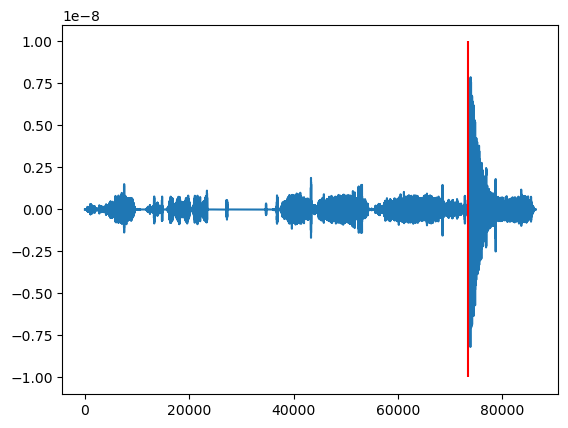

572415


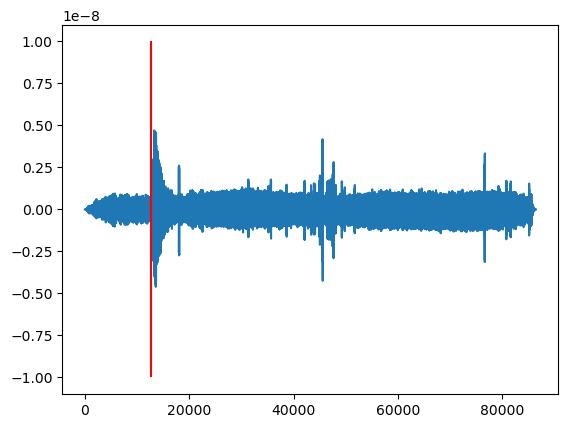

572411


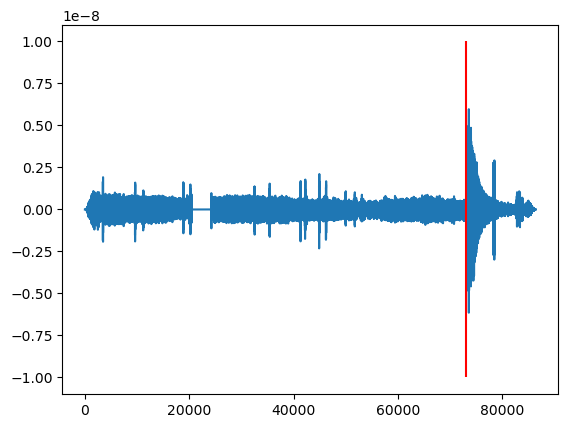

572411


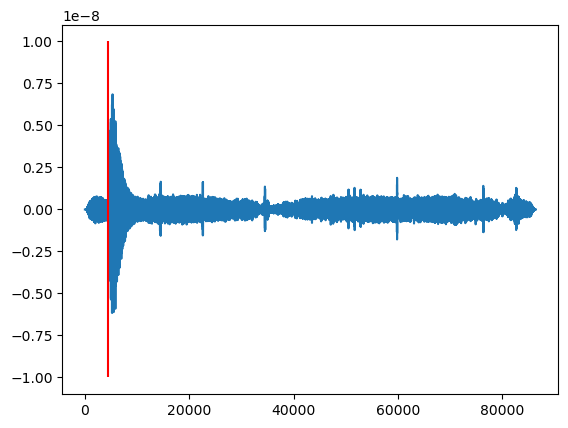

572415


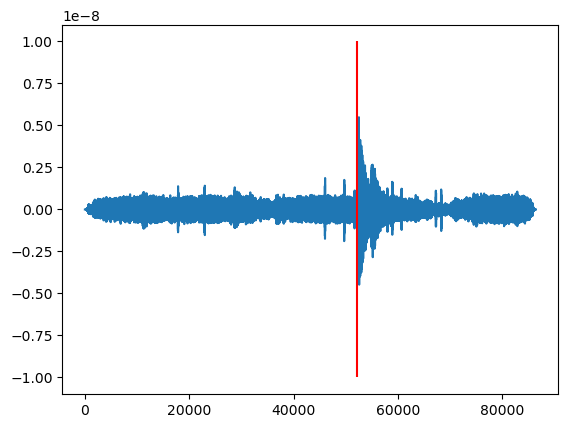

572411


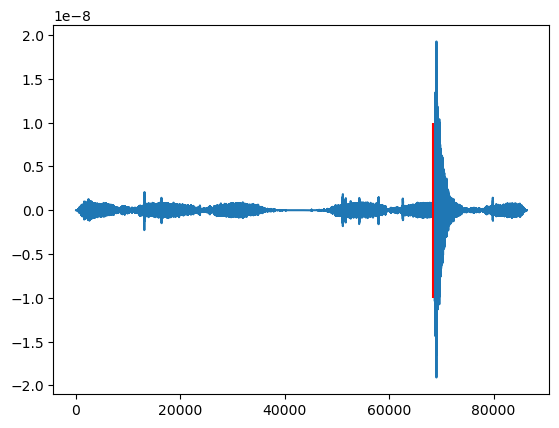

572418


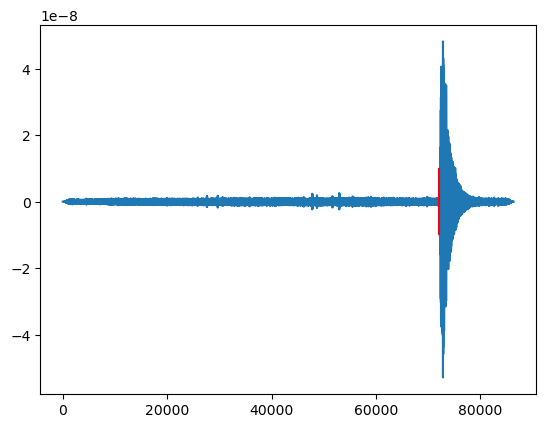

572423


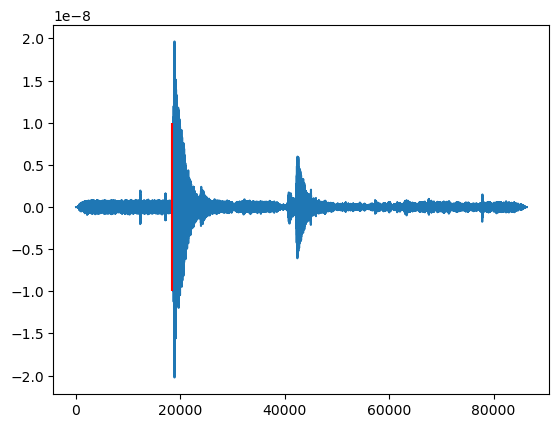

572411


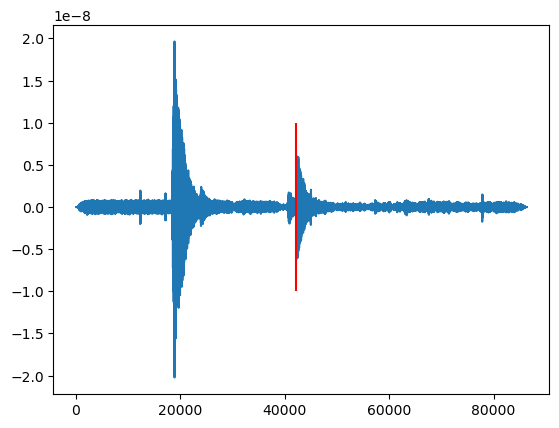

572411


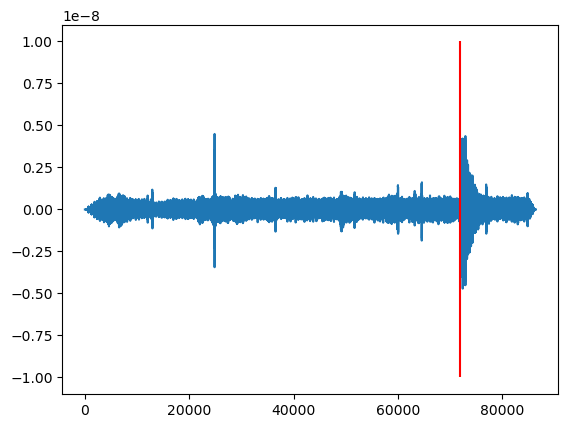

572423


In [10]:
data = SismicDataset()
for i in range(10):
    x, z ,y ,df= data.__getitem__(i)
    x.shape
    plt.plot(z,x)
    plt.vlines(y,-1e-8,1e-8,colors="red")
    plt.show()
    print(len(x))



In [11]:
def CFT(tr_data_filt_norm, df):

    #STA/LTA
    # How long should the short-term and long-term window be, in seconds?\
    sta_len = 120       #120
    lta_len = 600       #600
    # sta_len = 1000
    # lta_len = 2000

    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    #cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    tr_data_filt_norm = tr_data_filt_norm.reshape(-1)
    cft = classic_sta_lta(tr_data_filt_norm, int(sta_len * df), int(lta_len * df))
    return cft

def test(cft):
    # Número de puntos en el arreglo
    n = len(cft)

    # Frecuencia de muestreo (puedes ajustarla dependiendo del contexto)
    sampling_rate = 1 #df  # Ajusta según corresponda

    # Realizar la FFT del arreglo
    cft_fft = fft(cft)

    # Crear las frecuencias correspondientes
    frequencies = fftfreq(n, d=sampling_rate)

    # Definir la frecuencia de corte para el filtro
    cutoff_freq = 0.0001/2 # Ajusta según lo que necesites

    # Aplicar el filtro pasa bajos: eliminar las frecuencias más altas que la frecuencia de corte
    cft_fft[np.abs(frequencies) > cutoff_freq] = 0

    # Realizar la inversa de la FFT para regresar al dominio temporal
    filtered_cft = ifft(cft_fft)

    # La señal filtrada está en dominio temporal (real)
    filtered_cft_real = np.real(filtered_cft)

    #print("Arreglo original:", cft)
    #print("Arreglo filtrado:", filtered_cft_real)
    return filtered_cft_real

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

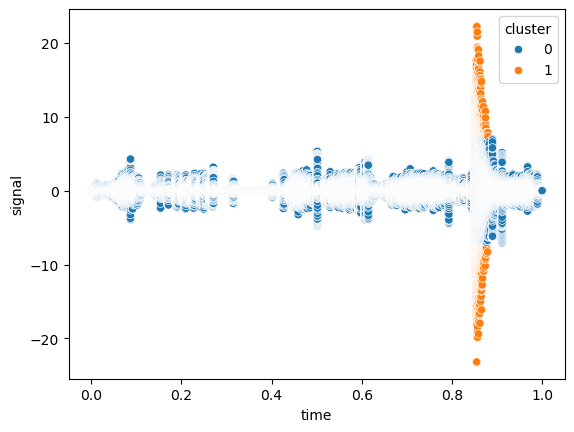

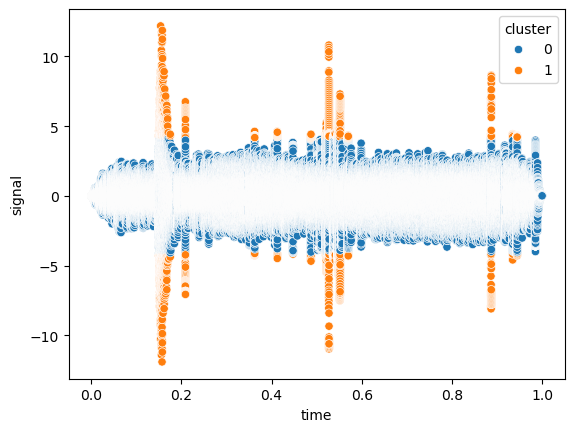

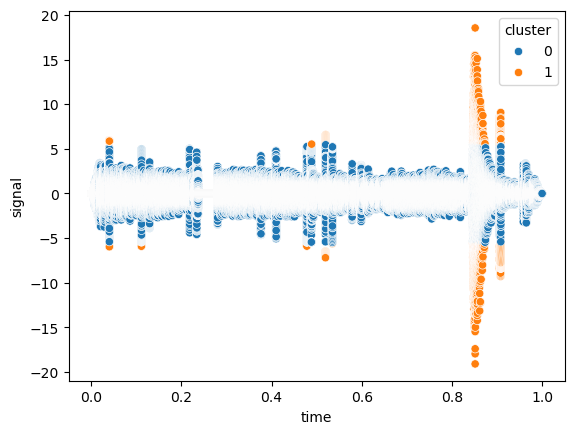

In [14]:
    
for i in range(3):
    signal ,tr_times, label, df = data.__getitem__(i)

    time_scaler = MinMaxScaler()
    signal_scaler = StandardScaler()

    Normalized_time = time_scaler.fit_transform(X= tr_times.reshape(-1,1))
    Normalized_label = time_scaler.transform(label.reshape(-1,1))
    Normalized_signal = signal_scaler.fit_transform(X= signal.reshape(-1,1))


    data_train = pd.DataFrame()

    data_train.insert(0,"time",Normalized_time.flatten())
    data_train.insert(0,"signal", Normalized_signal.flatten())
    data_train.insert(0,"x2",Normalized_signal*Normalized_signal)

    aux = np.copy(np.abs(Normalized_signal))
    aux[1:-1] = np.abs(Normalized_signal[1:-1] -Normalized_signal[2:])
    data_train.insert(0,"iminext", aux)

    cft = CFT(signal,df)
    filtered = test(cft)
    data_train.insert(0,"fft", filtered)




    model = KMeans(n_clusters=2)
    selection = data_train.select("fft","x2","signal", "iminext","time")
    model.fit(selection)
    cluster = model.predict(selection)
    data_train.insert(0,"cluster",cluster)
    sns.scatterplot(data= data_train,x="time",y="signal",hue="cluster")
    plt.show()



